In [1]:
from elementos_matriz import *
import matplotlib.pyplot as plt

from qiskit.quantum_info import SparsePauliOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator

from scipy.optimize import minimize

# Simulaciones con ruido
from qiskit_ibm_runtime import QiskitRuntimeService

In [2]:
def elementos_matriz(d, a, RA, RB, ZA, ZB):
    """ Elementos de matriz para H2 con la base STO-3G

    Parámetros:
        d: vector de coeficientes de contracción
        a: vector de exponentes orbitales gaussianos
        (RA, RB): coord. del núcleo (A, B)
        (ZA, ZB): carga del núcleo (A, B)
    """
    # elementos de un cuerpo
    f11 = fpp(1, d, a, RA, RB, ZA, ZB)
    f33 = fpp(3, d, a, RA, RB, ZA, ZB)
    # elementos de dos cuerpos
    g1212 = gpqrs([1,2,1,2], d, a, RA, RB)
    g3434 = gpqrs([3,4,3,4], d, a, RA, RB)
    g1313 = gpqrs([1,3,1,3], d, a, RA, RB)
    g1331 = gpqrs([1,3,3,1], d, a, RA, RB)

    return f11, f33, g1212, g3434, g1313, g1331

# Hartree-Fock

In [3]:
def energy_HF(d, a, RA, RB, ZA, ZB):
    """ Cálculo de la energía mediante el método de Hartree-Fock (HF)
    
     Parámetros:
        d: vector de coeficientes de contracción
        a: vector de exponentes orbitales gaussianos
        (RA, RB): coord. del núcleo (A, B)
        (ZA, ZB): carga del núcleo (A, B)
    """
    f11, f33, g1212, g3434, g1313, g1331 = elementos_matriz(d, a, RA, RB, ZA, ZB)
    h_nuc = 1/(np.linalg.norm(RA-RB))
    E0 = 2*f11 + g1212
    Etot = E0 + h_nuc
    
    return Etot

# VQE

In [4]:
def loadIBMservice():
    # Leer el API token
    with open("ibm_token.txt", "r") as file:
        api_token = file.read().strip()
    
    # Leer el CRN
    with open("ibm_CRN.txt", "r") as file:
        CRN = file.read().strip()
    
    service = QiskitRuntimeService(channel='ibm_cloud', token=api_token, instance=CRN)
    return service

In [5]:
def H2_Hamiltoniano_JW(d, a, RA, RB, ZA, ZB):
    """ Hamiltoniano de la molécula de hidrógeno H2 mediante la transformación de Jordan-Wigner (JW)

    Parámetros:
        d: vector de coeficientes de contracción
        a: vector de exponentes orbitales gaussianos
        (RA, RB): coord. del núcleo (A, B)
        (ZA, ZB): carga del núcleo (A, B)
    """
    f11, f33, g1212, g3434, g1313, g1331 = elementos_matriz(d, a, RA, RB, ZA, ZB) # elementos de matriz
    h12 = (2*f11 + g1212 + 2*g1313 - g1331)/4
    h34 = (2*f33 + g3434 + 2*g1313 - g1331)/4
    h0 = f11 + f33 + g1212/4 + g3434/4 + g1313 - g1331/2
    
    hamiltoniano = SparsePauliOp.from_list(
        [
            ("IIII", h0),
            ("IIIZ", -h12), ("IZII", -h12),
            ("IIZI", -h34), ("ZIII", -h34),
            ("IZIZ", g1212/4),
            ("IIZZ", (g1313-g1331)/4), ("ZZII", (g1313-g1331)/4),
            ("ZIIZ", g1313/4), ("XYXY", g1331/4),
            ("XYYX", -g1331/4), ("YXXY", -g1331/4),
            ("YXYX", g1331/4), ("IZZI", g1313/4),
            ("ZIZI", g3434/4),
        ]
    )
    return hamiltoniano

In [6]:
# creación del problema
num_spatial_orbitals  = 2 # dos orbitales espaciales (ligante y antiligante)
num_particles  = (1,1) # una partícula con espín arriba y otra con espín abajo
qubit_mapper  = JordanWignerMapper() # mapeo de qubits

# Estimador
estimator = Estimator()

In [7]:
def funcion_costo(params, ansatz_isa, hamiltonian, estimator):
    """ Regresa el estimado de energía a partir del estimador

    Parámetros:
        params (ndarray): Arreglo de parámetros del ansatz
        ansatz_isa (QuantumCircuit): Circuito ansatz parametrizado
        hamiltonian (SparsePauliOp): Representación operacional del Hamiltoniano
        estimator (Estimator): Instancia de la primitiva estimador

    Devuelve:
        float: Estimación de energía
    """

    pub = (ansatz_isa, hamiltonian, [params])
    job = estimator.run([pub])
    result = job.result()
    pub_result = result[0]

    cost = pub_result.data.evs[0]
    return cost

In [14]:
def VQE(distancia=1.4, backend=None, optimization_level=2, init_params=None):
    """ Variational Quantum Eigensolver

    Parámetros:
        distancia (float):
        backend (str):
        optimization_level (int): 
        init_params (ndarray) : 

    Devuelve:
        float: Estimación de energía
    """

    # (1) Estado inicial
    init_state = HartreeFock(num_spatial_orbitals, num_particles, qubit_mapper)
    # (2.1) Ansatz
    ansatz = UCCSD(num_spatial_orbitals, num_particles, qubit_mapper, initial_state=init_state)
    # (2.2) Parámetros iniciales del ansatz
    if init_params is None:
        num_params = ansatz.num_parameters # número de parámetros T_i en el ansatz
        init_params = [0] * num_params # parámetros iniciales (todos cero)
    else:
        init_params = init_params # parámetros iniciales

    # (3) Hamiltoniano
    RB = np.array([distancia, 0, 0])
    hamiltonian_isa = H2_Hamiltoniano_JW(d, a, RA, RB, ZA, ZB)
    
    # Simulador
    if backend is None: # sin ruido
        aer = AerSimulator()
    else: # con ruido
        service = loadIBMservice()
        real_backend = service.backend(backend) # QPU (Quantum Processing Unit) para el perfil de ruido
        aer = AerSimulator.from_backend(real_backend)
        ### Transpilar Hamiltoniano
        # se fija el número de términos de Pauli del 'SparsePauliOperator' igual que el número de qubits del simulador
        hamiltonian_isa = hamiltonian_isa.apply_layout(layout=None, num_qubits=aer.num_qubits)

    # Pass Manager
    pass_manager = generate_preset_pass_manager(backend=aer, optimization_level=optimization_level)
    ansatz_isa = pass_manager.run(ansatz)
    
    # Minimización
    vqe_energy = minimize(funcion_costo, init_params, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")
    optimized_params = vqe_energy.x # parámetros optimizados

    # Resultado
    hnuc = 1/(np.linalg.norm(RA-RB)) # energía de repulsión nuclear
    energy_H2 = vqe_energy.fun + hnuc # energía total

    return optimized_params, energy_H2

In [9]:
# Rango de distancias interatómicas
distances = np.arange(0.35, 7.6, 0.3) # de 0.35ua hasta 7.6ua en pasos de 0.3ua
total = len(distances)

In [10]:
%%time
print("Método de Hartree-Fock\n")
HF_energy = [] # energías mediante el método de Hartree-Fock

counter = 10
for i in range(total):
    # Hartree-Fock
    RB = np.array([distances[i], 0, 0])
    energy = energy_HF(d, a, RA, RB, ZA, ZB)
    HF_energy.append(energy)

    val = int(np.round((i+1)*100/total))
    if val >= counter:
        print(f"{val}% de casos calculados. {i+1} de {total}.")
        counter += 10

Método de Hartree-Fock

12% de casos calculados. 3 de 25.
20% de casos calculados. 5 de 25.
32% de casos calculados. 8 de 25.
40% de casos calculados. 10 de 25.
52% de casos calculados. 13 de 25.
60% de casos calculados. 15 de 25.
72% de casos calculados. 18 de 25.
80% de casos calculados. 20 de 25.
92% de casos calculados. 23 de 25.
100% de casos calculados. 25 de 25.
CPU times: total: 21.7 s
Wall time: 29.4 s


In [15]:
%%time
print("VQE - optimización máxima - sin ruido\n")
optimized_params, VQE_energy = [], []

counter = 10
for i in range(total):
    # Parámetros iniciales.
    ## La iteración i+1 considera como parámetros iniciales los parámetros optimizados de la i-ésima iteración
    init_params = optimized_params[i-1] if (i != 0) else None
    
    # VQE, optimización máxima, sin ruido
    params, energy_VQE = VQE(distances[i], None, 3, init_params)
    optimized_params.append(params)
    VQE_energy.append(energy_VQE)

    val = int(np.round((i+1)*100/total))
    if val >= counter:
        print(f"{val}% de casos calculados. {i+1} de {total}.")
        counter += 10

VQE - optimización máxima - sin ruido

12% de casos calculados. 3 de 25.
20% de casos calculados. 5 de 25.
32% de casos calculados. 8 de 25.
40% de casos calculados. 10 de 25.
52% de casos calculados. 13 de 25.
60% de casos calculados. 15 de 25.
72% de casos calculados. 18 de 25.
80% de casos calculados. 20 de 25.
92% de casos calculados. 23 de 25.
100% de casos calculados. 25 de 25.
CPU times: total: 1min 13s
Wall time: 1min 58s


El perfil de ruido por emplear será el del QPU 'ibm_brisbane'. A continuación se imprimen algunas de sus características.

In [16]:
service = loadIBMservice()
backend = service.backend("ibm_brisbane")
 
print(
    f"Name: {backend.name}\n"
    f"Version: {backend.version}\n"
    f"No. of qubits: {backend.num_qubits}\n"
)

Name: ibm_brisbane
Version: 2
No. of qubits: 127



In [17]:
%%time
print("VQE - optimización máxima - con ruido : QPU 'ibm_brisbane'\n")
noisy_optimized_params, noisy_VQE_energy = [], []

counter = 10
for i in range(total):
    # Parámetros iniciales.
    ## La iteración i+1 considera como parámetros iniciales los parámetros optimizados de la i-ésima iteración
    init_params = noisy_optimized_params[i-1] if (i != 0) else None
    
    noisy_params, noisy_energy_VQE = VQE(distances[i], "ibm_brisbane", 3)
    noisy_optimized_params.append(noisy_params)
    noisy_VQE_energy.append(noisy_energy_VQE)

    val = int(np.round((i+1)*100/total))
    if val >= counter:
        print(f"{val}% de casos calculados. {i+1} de {total}.")
        counter += 10

VQE - optimización máxima - con ruido : QPU 'ibm_brisbane

12% de casos calculados. 3 de 25.
20% de casos calculados. 5 de 25.
32% de casos calculados. 8 de 25.
40% de casos calculados. 10 de 25.
52% de casos calculados. 13 de 25.
60% de casos calculados. 15 de 25.
72% de casos calculados. 18 de 25.
80% de casos calculados. 20 de 25.
92% de casos calculados. 23 de 25.
100% de casos calculados. 25 de 25.
CPU times: total: 5min 7s
Wall time: 7min 6s


In [18]:
# Valores de la energía en función de la distancia interatómica reportada por Kandala, et. al.
x_Kandala = np.array([0.204,0.299,0.401,0.591,0.73,0.985,1.19,1.387,1.577,1.788,1.978,2.985,3.974]) # distancia interatómica (Angstroms)
y_Kandala = np.array([0.194,-0.536,-0.848,-1.076,-1.109,-1.061,-1.039,-1.006,-0.979,-0.921,-0.936,-0.924,-0.927]) # energía (hartrees)

In [ ]:
def graficarEnergia():
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    vqe0, = axs[0].plot(distances, VQE_energy, label="VQE", linewidth=2.5, color='forestgreen')
    classic0, = axs[0].plot(distances, HF_energy, label="Hartree-Fock", linestyle='--', linewidth=2.5, color='limegreen')
    kandala0, = axs[0].plot(x_Kandala/0.529177249, y_Kandala, label="Kandala", linestyle='None', linewidth=None, marker='o', color='black')
    axs[0].set_xlabel("Distancia interatómica (Unidades Atómicas)", fontsize='xx-large', labelpad=10)
    axs[0].set_ylabel("Energía (Hartrees)", fontsize='xx-large', labelpad=10)
    
    axs[1].plot(distances*0.529177249, VQE_energy, label="VQE", linewidth=2.5, color='crimson')
    axs[1].plot(distances*0.529177249, HF_energy, label="Hartree-Fock", linestyle='--', linewidth=2.5, color='tomato')
    axs[1].plot(x_Kandala, y_Kandala, label="Kandala", linestyle='None', linewidth=None, marker='o', color='black')
    axs[1].set_xlabel("Distancia interatómica (Angstrom)", fontsize='xx-large', labelpad=10)
    
    order = [2,1,0]
    for ax in axs:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize='xx-large', loc='upper right')
        ax.tick_params(axis='both', which='major', labelsize='xx-large')
        ax.grid()
    
    nombre = 'VQE'
    fig.subplots_adjust(wspace=0.2) # espacio entre figuras
    # plt.savefig(f"imgs/{nombre}.svg", format="svg")
    plt.show()

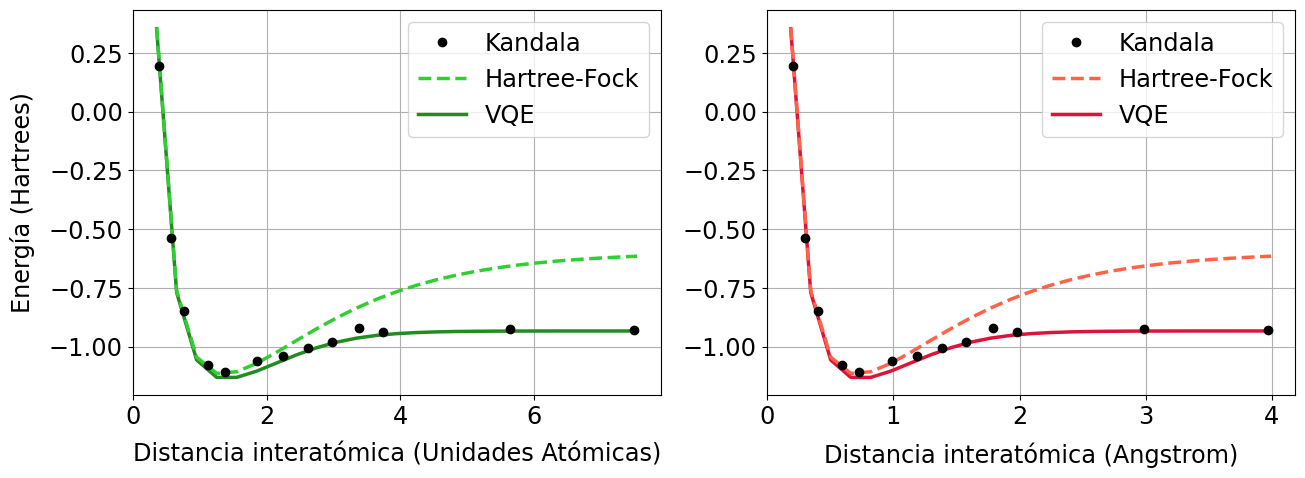

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

vqe0, = axs[0].plot(distances, VQE_energy, label="VQE", linewidth=2.5, color='forestgreen')
# vqeNoisy = axs[0].plot(distances, noisy_VQE_energy, label="Noisy VQE", linestyle='-.', linewidth=2.5, color='blue')
classic0, = axs[0].plot(distances, HF_energy, label="Hartree-Fock", linestyle='--', linewidth=2.5, color='limegreen')
kandala0, = axs[0].plot(x_Kandala/0.529177249, y_Kandala, label="Kandala", linestyle='None', linewidth=None, marker='o', color='black')
axs[0].set_xlabel("Distancia interatómica (Unidades Atómicas)", fontsize='xx-large', labelpad=10)
axs[0].set_ylabel("Energía (Hartrees)", fontsize='xx-large', labelpad=10)

axs[1].plot(distances*0.529177249, VQE_energy, label="VQE", linewidth=2.5, color='crimson')
# axs[1].plot(distances*0.529177249, noisy_VQE_energy, label="Noisy VQE", linestyle='-.', linewidth=2.5, color='crimson')
axs[1].plot(distances*0.529177249, HF_energy, label="Hartree-Fock", linestyle='--', linewidth=2.5, color='tomato')
axs[1].plot(x_Kandala, y_Kandala, label="Kandala", linestyle='None', linewidth=None, marker='o', color='black')
axs[1].set_xlabel("Distancia interatómica (Angstrom)", fontsize='xx-large', labelpad=10)

order = [2,1,0]
for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize='xx-large', loc='upper right')
    ax.tick_params(axis='both', which='major', labelsize='xx-large')
    ax.grid()

nombre = 'VQE'
fig.subplots_adjust(wspace=0.2) # espacio entre figuras
# plt.savefig(f"imgs/{nombre}.svg", format="svg")
plt.show()

In [21]:
t0 = [params[0] for params in optimized_params]
t1 = [params[1] for params in optimized_params]
t2 = [params[2] for params in optimized_params]

noisy_t0 = [params[0] for params in noisy_optimized_params]
noisy_t1 = [params[1] for params in noisy_optimized_params]
noisy_t2 = [params[2] for params in noisy_optimized_params]

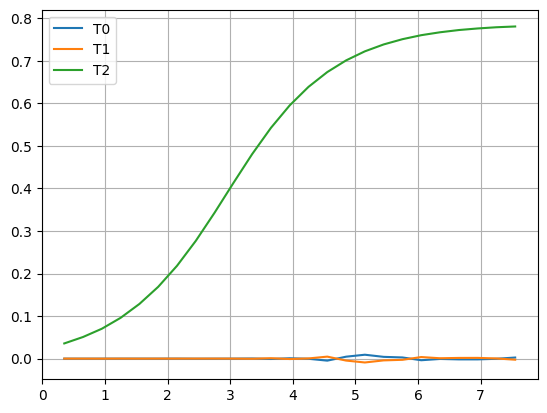

In [22]:
plt.plot(distances, t0, label="T0")
plt.plot(distances, t1, label="T1")
plt.plot(distances, t2, label="T2")
# plt.plot(distances, VQE_energy)
plt.legend()
plt.grid()
plt.show()

In [23]:
# ¿T0 y T1 comienzan a ser relevantes aprox en el punto de inflexión de T2?
# ¿Qué otro comportamiento podría haber alrededor de ese punto que cambie el comportamiento de T0 y T1?

In [24]:
ansatz.decompose().draw()

NameError: name 'ansatz' is not defined

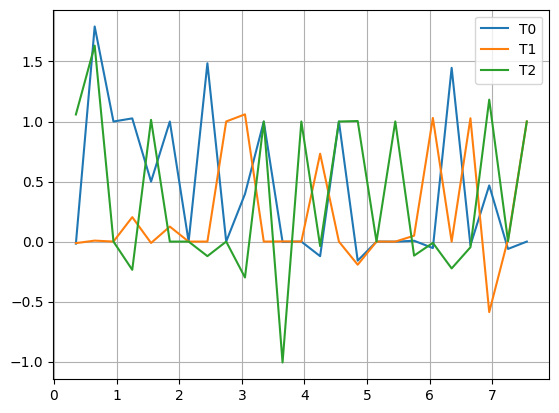

In [25]:
plt.plot(distances, noisy_t0, label="T0")
plt.plot(distances, noisy_t1, label="T1")
plt.plot(distances, noisy_t2, label="T2")
# plt.plot(distances, VQE_energy)
plt.legend()
plt.grid()
plt.show()